<a href="https://colab.research.google.com/github/shashanksrajak/neural-networks-from-zero/blob/main/karpathy-lectures/lec1_building_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Backprop and Neural Network from Scratch

References:

[Github Repo](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb)

[Youtube Tutorial](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1&t=15s)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

## Derivatives

In [24]:
def f(x):
  return 3*x**2 - 4*x + 5 # quadratic equation

In [25]:
f(3.0)

20.0

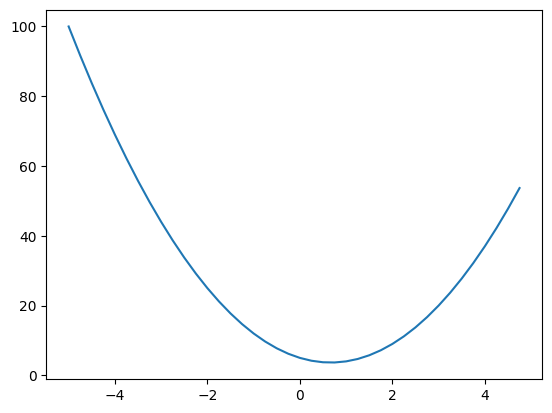

In [26]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [27]:
h = 0.001
x = 2/3
f(x+h), f(x)

(3.6666696666666665, 3.666666666666667)

In [28]:
(f(x+h)-f(x))/h

0.0029999999995311555

In [29]:
# d is a function of a, b and c, now we are interested in knowing how d will respond if we change a, b, c

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [30]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

# change a a little bit
a += h
d2 = a*b + c

print(d1)
print(d2)
print("Slope", (d2-d1)/h)

4.0
3.999699999999999
Slope -3.000000000010772


In [31]:
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

# change b a little bit
b += h
d2 = a*b + c

print(d1)
print(d2)
print("Slope", (d2-d1)/h)

4.0
4.0002
Slope 2.0000000000042206


## Building Neural Network

In [30]:
class Value:
  def __init__(self, data, _children=(), _op='', label='') -> None:
    self.data = data
    self.grad = 0 # initially every node will have a zero gradient with Loss function L
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda: None

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data

    out._backward = backward
    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'



d = e + c
d.label = 'd'

f = Value(-2.0, label='f')

L = d * f
L.label = 'L'

print(d)

Value(data=4.0)


In [33]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [34]:
d._op

'+'

In [31]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

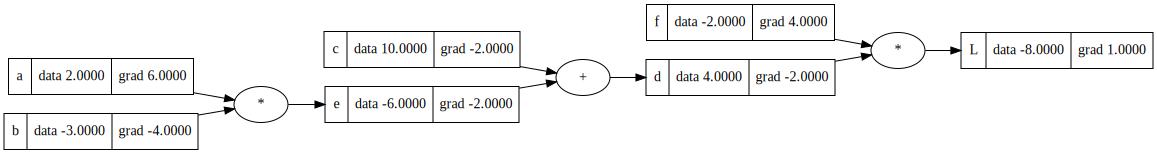

In [38]:
draw_dot(L)

### Example 1: Mannual calculation of gradients
The derivative formula is
$$\frac{f(x+h) - f(x)}{h} $$

also we need `chain rule` to calculate derivates of L with respect to each node i.e.

$$\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} $$


In [37]:
L.grad = 1.0
# derivative of L wrt L will be 1, obviously

# dL/dd = ((d+h)*f) - d*f / h = (df + hf - df)/h = f
d.grad = -2.0
f.grad = 4.0

# dL/dc = dL/dd * dd/dc = ?
# dd/dc  = 1
# hence => dL/dc = -2 * 1 = -2
# similarly dL/de = dL/dd * dd/de = -2 * 1 = -2
c.grad = -2.0
e.grad = -2.0

# dL/da = dL/dc * dc/da = -2 * -3 = 6
# dL/db = dL/dc * dc/db = -2 * 2 = -4
a.grad = 6.0
b.grad = -4.0

A simple optimization example:
Where we nudge the values of a, b, c and f and see how L changes.

In [16]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


### Example 2 - A Single Neuron

A single neuron gets weighted input(s), applies a bias term to it and then finally applies an activation function to generate the output e.g. tanh is an activation function, check the grapg below.

![image](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

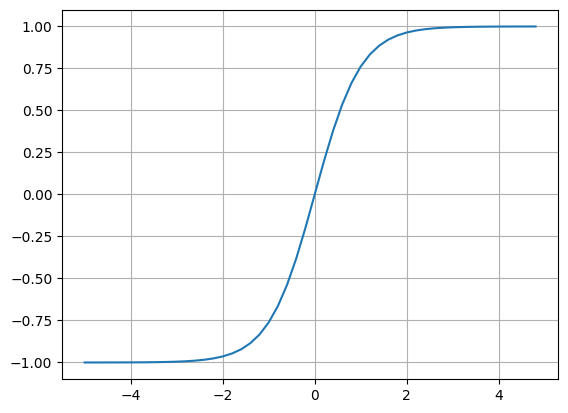

In [39]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [83]:
# 2 inputs to single neuron

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

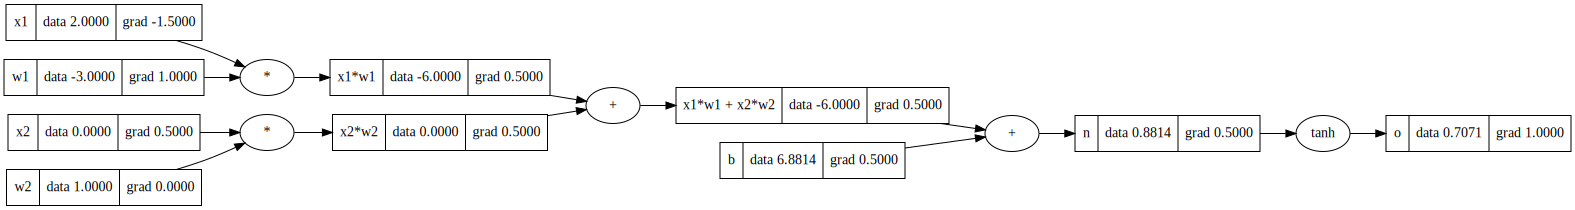

In [86]:
draw_dot(o)

#### calculate gradients for each node here (manual calculations)
So in a neural net, what really matters is derivative of output wrt parameters, not the input values.

NOTE: first we tried manual calculations to understand the math, then we implemented a `_backward` method in Value class to calculate the derivatives.


In [67]:
o.grad = 1

# do/dn => o = tanh(n) => 1 - tanh^2(n)
n.grad = 1 - math.tanh(n.data)**2
print(n.grad)

# do/db = do/dn*dn/db
b.grad = 0.5
x1w1x2w2.grad = 0.5


x1w1.grad = 0.5
x2w2.grad = 0.5


x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


0.4999999999999998


#### using the `_backward` method now

In [71]:
o.grad = 1.00 # this is the base casem we need to set 1

# call backward methods in reverse order of nodes
o._backward()

In [73]:
n._backward()

In [77]:
b._backward() # this will just return None - leaf node, no backward prop

In [78]:
x1w1x2w2._backward()

In [79]:
x1w1._backward()

In [80]:
x2w2._backward()

### Toplogical Sort for implementing Backward Prop for whole Expression Graph

![Image](https://miro.medium.com/v2/resize:fit:1400/1*uMg_ojFXts2WZSjcZe4oRQ.png)

Instead of calling `_backward` manually we will use the `backward` method to calculate for the whole expression graph of neural network

In [85]:
o.backward()

-------

## Implementing Same Thing with PyTorch

In [87]:
import torch

In [88]:
torch.Tensor([1.2])

tensor([1.2000])

In [89]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [90]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

## Creating a Neural Net Library

1. First create a single `Neuron`
2. Creating a `Layer` of neurons
3. Create a `MLP` multi layer perceptron

In [40]:
class Neuron:
  def __init__(self, nin):
    """
    nin: number of inputs to this neuron
    """
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # init weight parameters with some random values as per the num of neurons
    self.b = Value(random.uniform(-1, 1)) # bias term

  def __call__(self, x):
    # w*x + b
    y = zip(self.w, x)
    # for item in y:
    #   print(item)

    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh() # this is applying the activation function on weighted sum of inputs plus bias term, we have only tanh but it can be users choice as well

    return out


class Layer:
  def __init__(self, nin, nout) -> None:
    """
    nin : number of inputs i.e. inputs which each neuron will receive
    nout : number of outputs required i.e. neruons in this layer
    """

    self.neurons = [Neuron(nin) for _ in range(nout)]


  def __call__(self, x):
    """
    x: the instance of inputs that will be going to each neuron
    """
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs


class MLP:
  def __init__(self, nin, nouts) -> None:
    """
    nouts: a list of all neurons in each layer
    """

    sz = [nin] + nouts

    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]


  def __call__(self, x):
    for layer in self.layers:
      # output of one layer becomes the input for next layer
      x = layer(x)
    return x



Creating one single neuron

In [41]:
x = [2.0, 3.0]
n = Neuron(2)

n(x)

Value(data=-0.9940375899471163)

Trying out one Layer of Neurons

In [42]:
L = Layer(2, 3)
L(x)

[Value(data=0.8013138401819653),
 Value(data=0.9540743999017229),
 Value(data=0.9636110918279158)]

In [43]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.681980078049405)

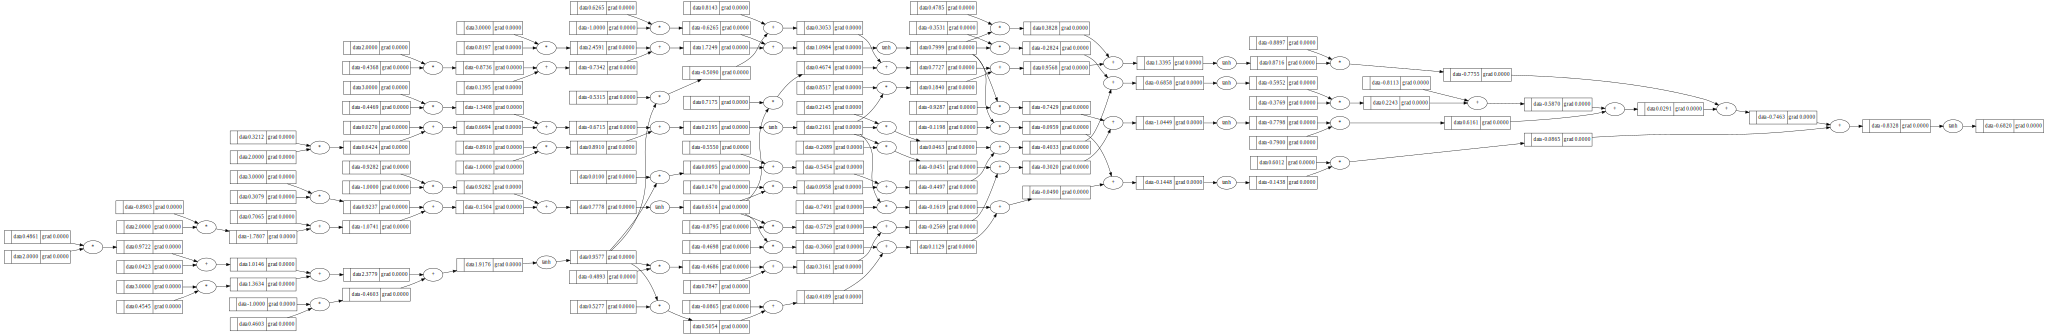

In [44]:
draw_dot(n(x))